# Useful Notebook: Generate Model Visualizations for Decision Tree and Genetic Programming Algorithms
**This notebook will allow users to generate a direct visualization of the models generated by algorithms that create directly interpretable models.** 

*This notebook is designed to run after having run STREAMLINE (at least phases 1-6) and will use the files from a specific STREAMLINE experiment folder, as well as save new output files to that same folder.*

***
## Notebook Details
Generates decision tree and genetic programming model visualizations for each CV model trained by STREAMLINE. Opens each pickled decision tree and genetic programming model and generates a respective vizualization, and optionally saves them to a new folder in the working experiment folder for the given target dataset (`model_evaluation`). Can be run for a single dataset or all datasets. Includes an option to only visualize the best performing model (out of all CV datasets) determined by the user specified target metric (testing data evaluation). Also provides the option to inverse the standard scaling applied to the dataset, so that feature values can be interpreted in their original scale.

Requirements:   conda install python-graphviz    
                

***
## Notebook Run Parameters
* This notbook has been set up to run 'as-is' on the experiment folder generated when running the demo of STREAMLINE in any mode (if no run parameters were changed). Note that in the basic demo, only Decision Tree is run, not Genetic Programming. 
* If you have run STREAMLINE on different target data or saved the experiment to some other folder outside of STREAMLINE, you need to edit `experiment_path` below to point to the respective experiment folder.

In [1]:
experiment_path = "../DemoOutput/demo_experiment" # path the target experiment folder 
targetDataName = None # 'None' if user wants to generate visualizations for all analyzed datasets
inverseScaling = True #If standardscaling was applied, revert scaled decision boundaries to their original data values.
bestOnly = False # Only generate viz. for best performing CV decision tree, otherwise generate one for each CV model.
targetMetric = 'ROC AUC' #Only used when bestOnly = True, names of different available metrics is included below.

#metricOptions = ['Balanced Accuracy','Accuracy','F1_Score','Sensitivity (Recall)','Specificity','Precision (PPV)','TP','TN','FP','FN','NPV','LR+','LR-','ROC_AUC','PRC_AUC','PRC_APS']

***
## Housekeeping
### Import Packages

In [2]:
import os
import pickle
import pandas as pd
import graphviz
from sklearn import tree
from subprocess import call
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Automatically detect dataset folder names

In [3]:
# Get dataset paths for all completed dataset analyses in experiment folder
datasets = os.listdir(experiment_path)

# Name of experiment folder
experiment_name = experiment_path.split('/')[-1] 

datasets = os.listdir(experiment_path)
remove_list = ['.DS_Store', 'metadata.pickle', 'metadata.csv', 'algInfo.pickle',
                'DatasetComparisons', 'jobs', 'jobsCompleted', 'logs',
                'KeyFileCopy', 'dask_logs',
                experiment_name + '_STREAMLINE_Report.pdf']
for text in remove_list:
    if text in datasets:
        datasets.remove(text)

datasets = sorted(datasets) # ensures consistent ordering of datasets
print("Analyzed Datasets: " + str(datasets))

Analyzed Datasets: ['hcc_data', 'hcc_data_custom']


## Define Necessary Methods

In [4]:
def unscaleTree(dotFilePath,original_headers,train_feature_list,scaler):
    """ Takes a dot file goes in and finds feature names next to associated cutoff values. Then inverse scales these cutoff 
    values using previously pickled scaler. Scaling is reversed by multiplying by '.scale_' and adding '.mean_' from scaler.
    These new values replace the old ones and the dot file is resaved with these changes."""
    my_file = open(dotFilePath)
    file_list = my_file.readlines()
    my_file.close()
    new_file_list = []
    for each in file_list: #Each line of file
        for feature in original_headers: #check each feature name
            if ('"'+str(feature)) in each:
                #Separate string by spaces
                stringList = each.split(' ')
                #Find chunk with \nentropy
                i = 0
                purityText = None
                for chunk in stringList:
                    if '\\nentropy' in chunk:
                        purityText = '\\nentropy'
                        #Isolate numerical value
                        targetValue = float(chunk.replace('\\nentropy',''))
                        break
                    elif '\\ngini' in chunk:
                        purityText = '\\ngini'
                        #Isolate numerical value
                        targetValue = float(chunk.replace('\\ngini',''))
                        break
                    i += 1
                #Get index of target feature name in original feature ordering
                feature_index = original_headers.index(feature)
                #Inverse scale based on specific feature scale index (mean and std)
                originalValue = (targetValue*scaler.scale_[feature_index]) + scaler.mean_[feature_index]
                #Replace numerical value in original dot file with inverse scaled 'original' value
                stringList[i] = str(originalValue)+purityText
                #Rebuild string
                each =  " ".join(stringList)
        new_file_list.append(each)
    my_file = open(dotFilePath, "w")
    new_file_contents = "".join(new_file_list)
    my_file.write(new_file_contents)
    my_file.close()

In [5]:
def generateTreePlot(experiment_path,each,algorithm,cvCount,max_index,scale_data,outcome_label,instance_label,inverseScaling,targetMetric):
    """ Takes all steps to generate a single decision tree visualization (for a given original dataset/cv training model).
    Includes option to inverse scale all feature values in tree decision boundaries (to their original value range, pre-scaling)"""
    #Pickle load target model
    modelInfo = experiment_path+"/"+each+'/models/pickledModels/'+algorithm+'_'+str(cvCount)+'.pickle' #Corresponding pickle file name with scalingInfo
    infile = open(modelInfo,'rb')
    model = pickle.load(infile)
    infile.close()
    #Pickle load target model
    if scale_data:
        #Scalar is in original data order and is specified for all features (pre-feature selection)
        scaleInfo = experiment_path+"/"+each+'/scale_impute/scaler_cv'+str(cvCount)+'.pickle' #Corresponding pickle file name with scalingInfo
        infile = open(scaleInfo,'rb')
        scaler = pickle.load(infile)
        infile.close()

    #Load feature names in their original order (corresponding to scaler order)
    original_headers = pd.read_csv(experiment_path+"/"+each+"/exploratory/OriginalFeatureNames.csv",sep=',').columns.values.tolist() #Get Original Headers

    #Load feature names for CV training dataset used to train model (features sorted alphabetically)
    cv_train_path = experiment_path+"/"+each+"/CVDatasets/"+each+'_CV_'+str(cvCount)+'_Train.csv'
    cv_train_data = pd.read_csv(cv_train_path, na_values='NA', sep = ",")
    #Get List of features in cv dataset (if feature selection took place this may only include a subset of original training data features)
    train_feature_list = list(cv_train_data.columns.values)
    train_feature_list.remove(outcome_label)
    try:
        train_feature_list.remove(instance_label)
    except:
        pass
    
    #Generate Tree dot file
    tree_path = experiment_path+'/'+each+'/model_evaluation/DT_Viz/'
    tree.export_graphviz(model, out_file=tree_path+"DT_Tree_"+str(cvCount)+'.dot', feature_names=train_feature_list, class_names=True, filled=True)
    if scale_data and inverseScaling:
        # Revert tree decision boundary values back to pre-scaled values for interpretability
        unscaleTree(tree_path+"DT_Tree_"+str(cvCount)+'.dot',original_headers,train_feature_list,scaler)
    # Generate Tree visualization
    graph = graphviz.Source.from_file(tree_path+"DT_Tree_"+str(cvCount)+'.dot')
    graph.format = "png" #Add this line to generate png files rather than pdfs.
    if cvCount == max_index: #This tree had best performance
        printMetric = targetMetric.replace(" ", "_")
        graph.render(tree_path+"DT_Tree_"+str(cvCount)+'_Best_'+printMetric)
    else:
        graph.render(tree_path+"DT_Tree_"+str(cvCount))
    return graph


In [6]:
def generateGPPlot(experiment_path,data_name,algorithm,cvCount,max_index,scale_data,outcome_label,instance_label,targetMetric):
    """ Takes all steps to generate a single genetic programming tree. https://gplearn.readthedocs.io/en/stable/examples.html """
    #Pickle load target model
    modelInfo = experiment_path+"/"+data_name+'/models/pickledModels/'+algorithm+'_'+str(cvCount)+'.pickle' #Corresponding pickle file name with scalingInfo
    infile = open(modelInfo,'rb')
    model = pickle.load(infile)
    infile.close()
    #Generate GP tree visualization
    tree_path = experiment_path+'/'+data_name+'/model_evaluation/GP_Viz/'
    dot_data = model._program.export_graphviz()
    graph = graphviz.Source(dot_data)
    graph.format = "png" #Add this line to generate png files rather than pdfs.
    if cvCount == max_index: #This tree had best performance
        printMetric = targetMetric.replace(" ", "_")
        graph.render(tree_path+"GP_Tree_"+str(cvCount)+'_Best_'+printMetric)
    else:
        graph.render(tree_path+"GP_Tree_"+str(cvCount))
    return graph

## Generate Decision Tree and/or Genetic Programming Tree Vizualizations

In [7]:
if targetDataName: # User specified one analyzed dataset above (if more than one were analyzed)
    for each in datasets:
        if not each == targetDataName:
            datasets.remove(each)
print("Vizualized Datasets: "+str(datasets))

# Unpickle metadata from previous phase
file = open(experiment_path+'/'+"metadata.pickle", 'rb')
metadata = pickle.load(file)
file.close()

# Unpickle algInfo from previous phase
file = open(experiment_path+'/'+"algInfo.pickle", 'rb')
algInfo = pickle.load(file)
file.close()

#Load variables specified earlier in the pipeline from metadata
outcome_label = metadata['Class Label']
instance_label = metadata['Instance Label']
cv_partitions = metadata['CV Partitions']
scale_data = metadata['Use Data Scaling']
do_DT = algInfo['Decision Tree'][0]
do_GP = algInfo['Genetic Programming'][0]
print("Number of CV Partitions: "+str(cv_partitions))


Vizualized Datasets: ['hcc_data', 'hcc_data_custom']
Number of CV Partitions: 3


ROC AUC values for each CV training set with DT:
[0.5889355742296918, 0.6470588235294118, 0.6785714285714285]
Best ROC AUC: 0.6785714285714285
---------------------------------------
hcc_data- CV Dataset: 2
---------------------------------------


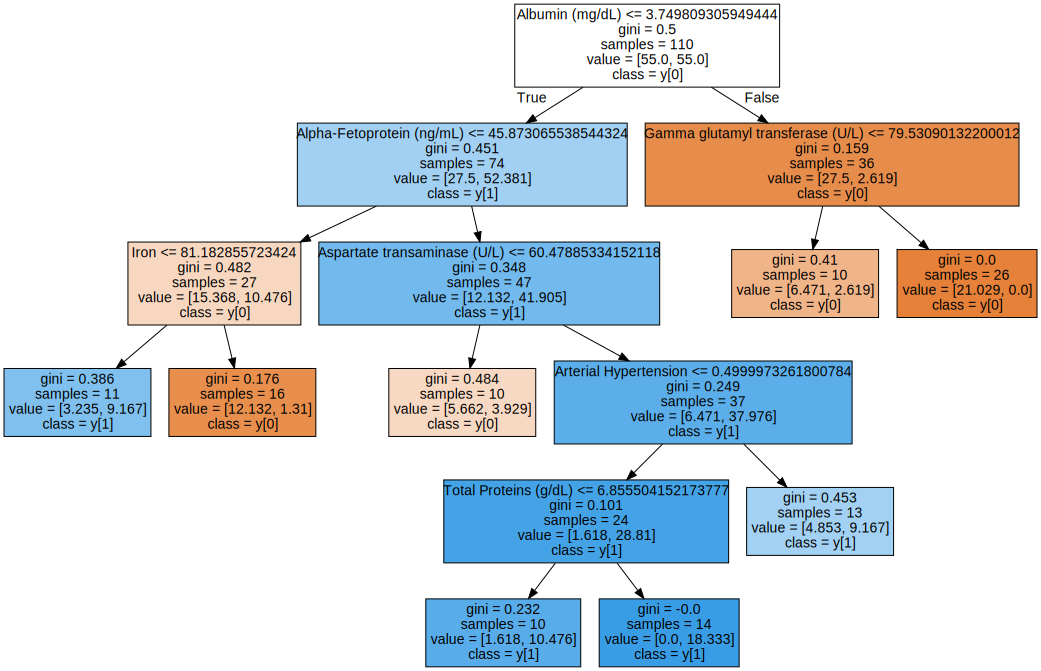

---------------------------------------
hcc_data- CV Dataset: 2
---------------------------------------


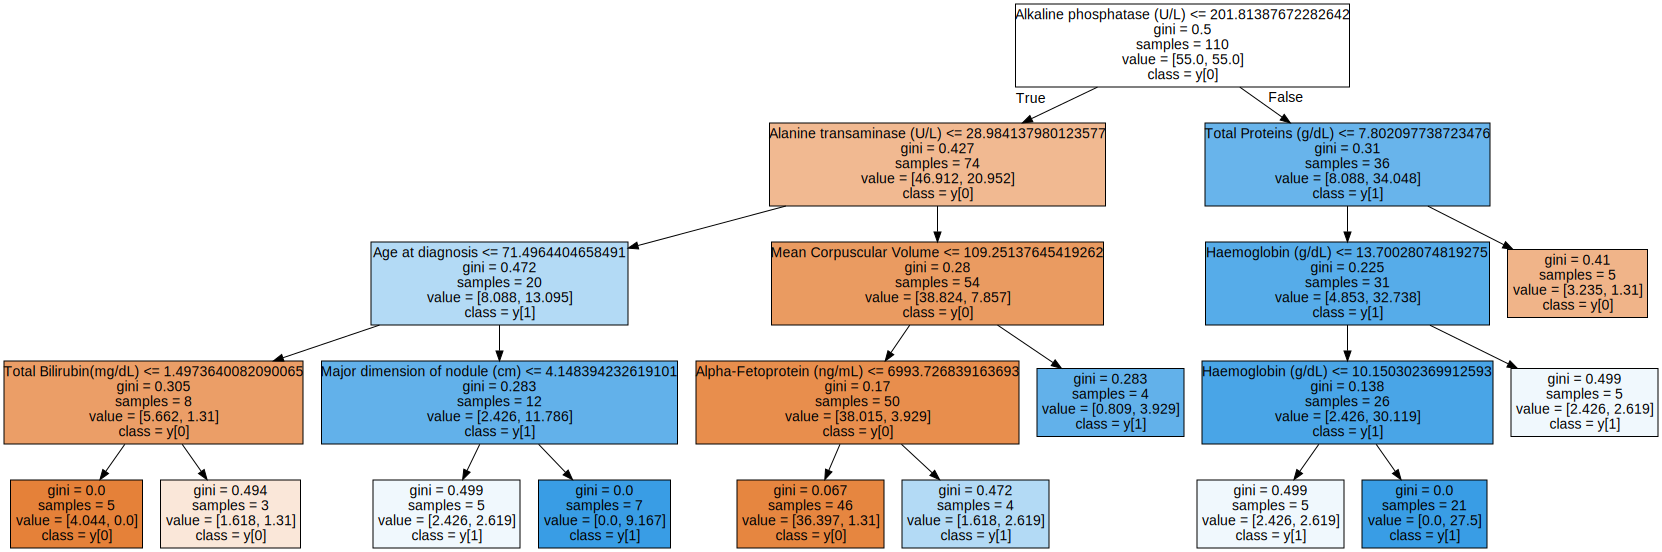

---------------------------------------
hcc_data- CV Dataset: 2
---------------------------------------


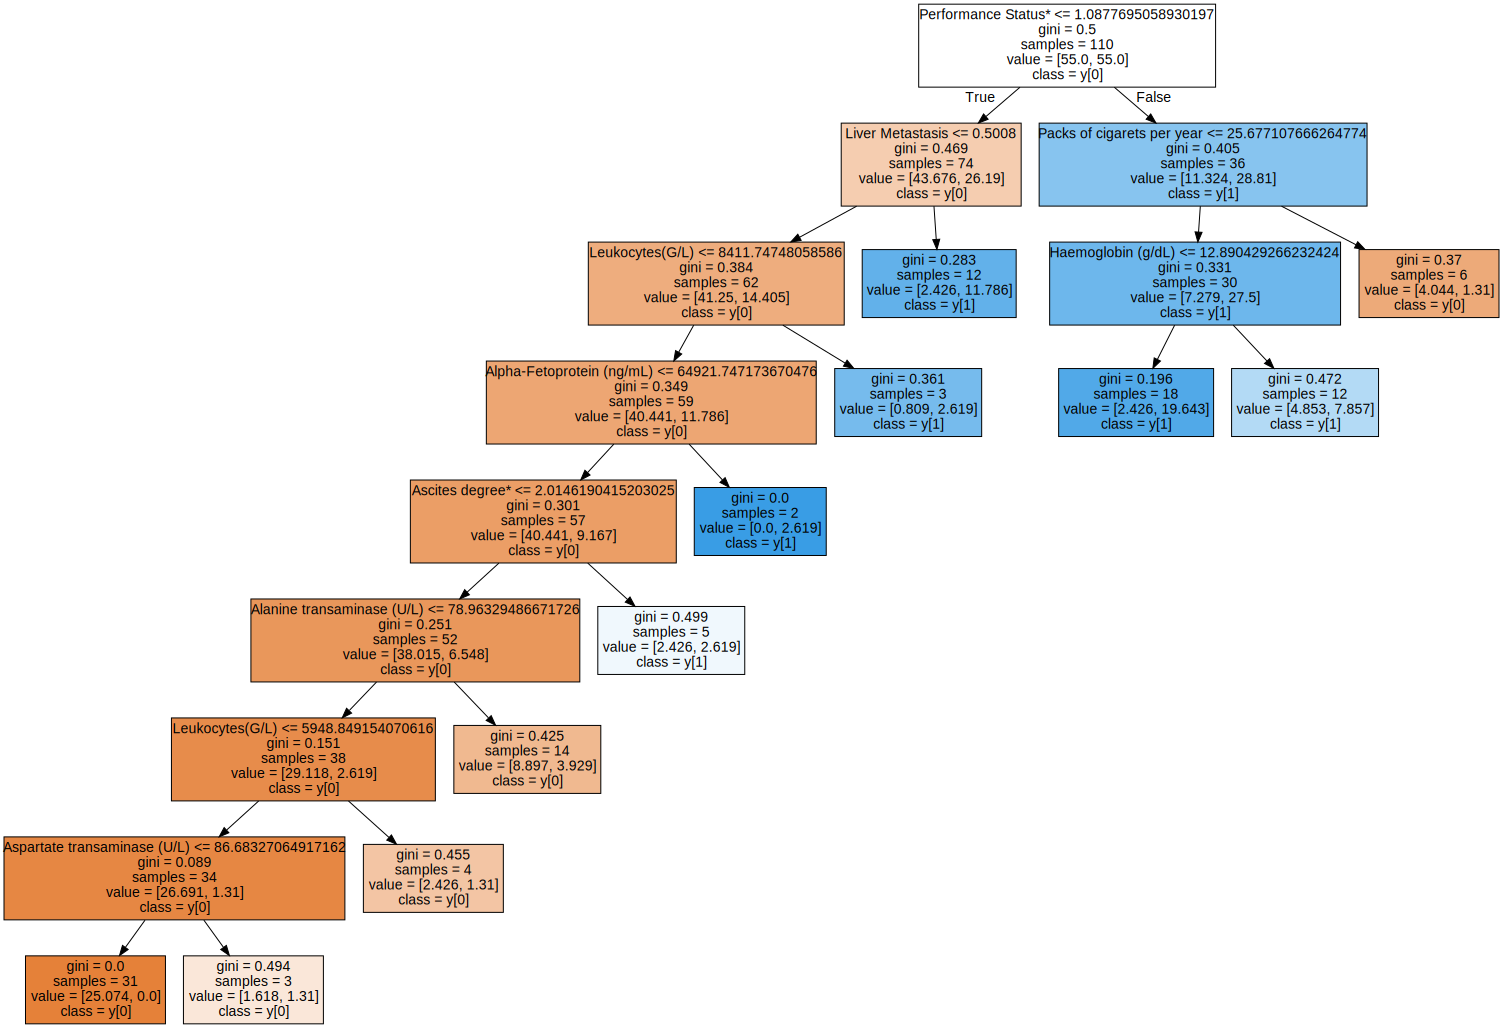

ROC AUC values for each CV training set with DT:
[0.6190476190476191, 0.6358543417366946, 0.7093837535014005]
Best ROC AUC: 0.7093837535014005
---------------------------------------
hcc_data_custom- CV Dataset: 2
---------------------------------------


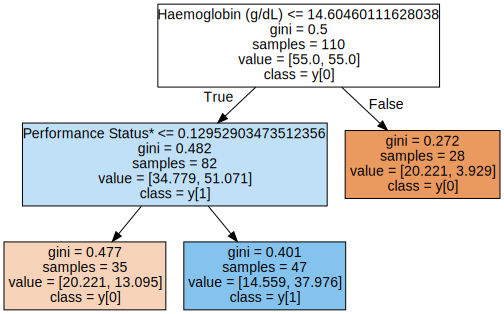

---------------------------------------
hcc_data_custom- CV Dataset: 2
---------------------------------------


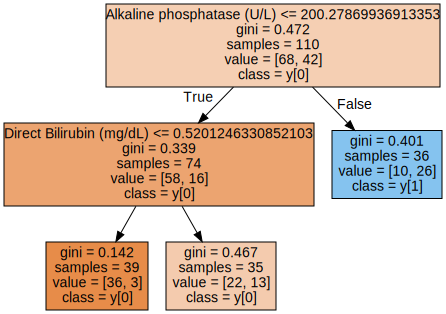

---------------------------------------
hcc_data_custom- CV Dataset: 2
---------------------------------------


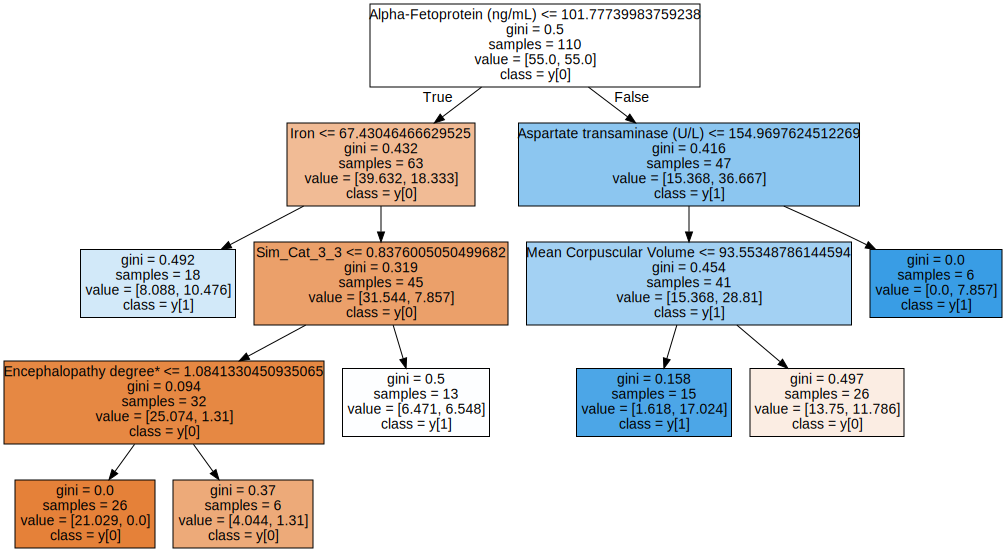

In [8]:
for each in datasets: #each analyzed dataset to make plots for
    if do_DT:
        #Create folder for tree vizualization files
        if not os.path.exists(experiment_path+'/'+each+'/model_evaluation/DT_Viz'):
            os.mkdir(experiment_path+'/'+each+'/model_evaluation/DT_Viz')
        #Open results dictionary to get metric for each CV
        cvMetrics = pd.read_csv(experiment_path+'/'+each+'/model_evaluation/DT_performance.csv',na_values='NA',sep=',')
        metric_cv_list = cvMetrics[targetMetric].tolist()
        #identify best CV
        max_value = max(metric_cv_list)
        max_index = metric_cv_list.index(max_value)
        # Vizualize best performing model
        print(str(targetMetric)+" values for each CV training set with DT:")
        print(str(metric_cv_list))
        print("Best "+str(targetMetric)+": "+str(max_value))
        for cvCount in range(0,int(cv_partitions)):
            graph = generateTreePlot(experiment_path,each,algInfo['Decision Tree'][1],cvCount,max_index,scale_data,outcome_label,instance_label,inverseScaling,targetMetric)
            print("---------------------------------------")
            print(each+"- CV Dataset: "+str(max_index))
            print("---------------------------------------")
            graph
                
    if do_GP:
        #Create folder for tree vizualization files
        if not os.path.exists(experiment_path+'/'+each+'/model_evaluation/GP_Viz'):
            os.mkdir(experiment_path+'/'+each+'/model_evaluation/GP_Viz')

        #Open results dictionary to get metric for each CV
        cvMetrics = pd.read_csv(experiment_path+'/'+each+'/model_evaluation/GP_performance.csv',na_values='NA',sep=',')
        metric_cv_list = cvMetrics[targetMetric].tolist()
        #identify best CV
        max_value = max(metric_cv_list)
        max_index = metric_cv_list.index(max_value)
        # Vizualize best performing model
        print(str(targetMetric)+" values for each CV training set with GP:")
        print(str(metric_cv_list))
        print("Best "+str(targetMetric)+": "+str(max_value))
        for cvCount in range(0,int(cv_partitions)):
            graph = generateGPPlot(experiment_path,each,algInfo['Genetic Programming'][1],cvCount,max_index,scale_data,outcome_label,instance_label,targetMetric)
            print("---------------------------------------")
            print(each+"- CV Dataset: "+str(max_index))
            print("---------------------------------------")
            graph